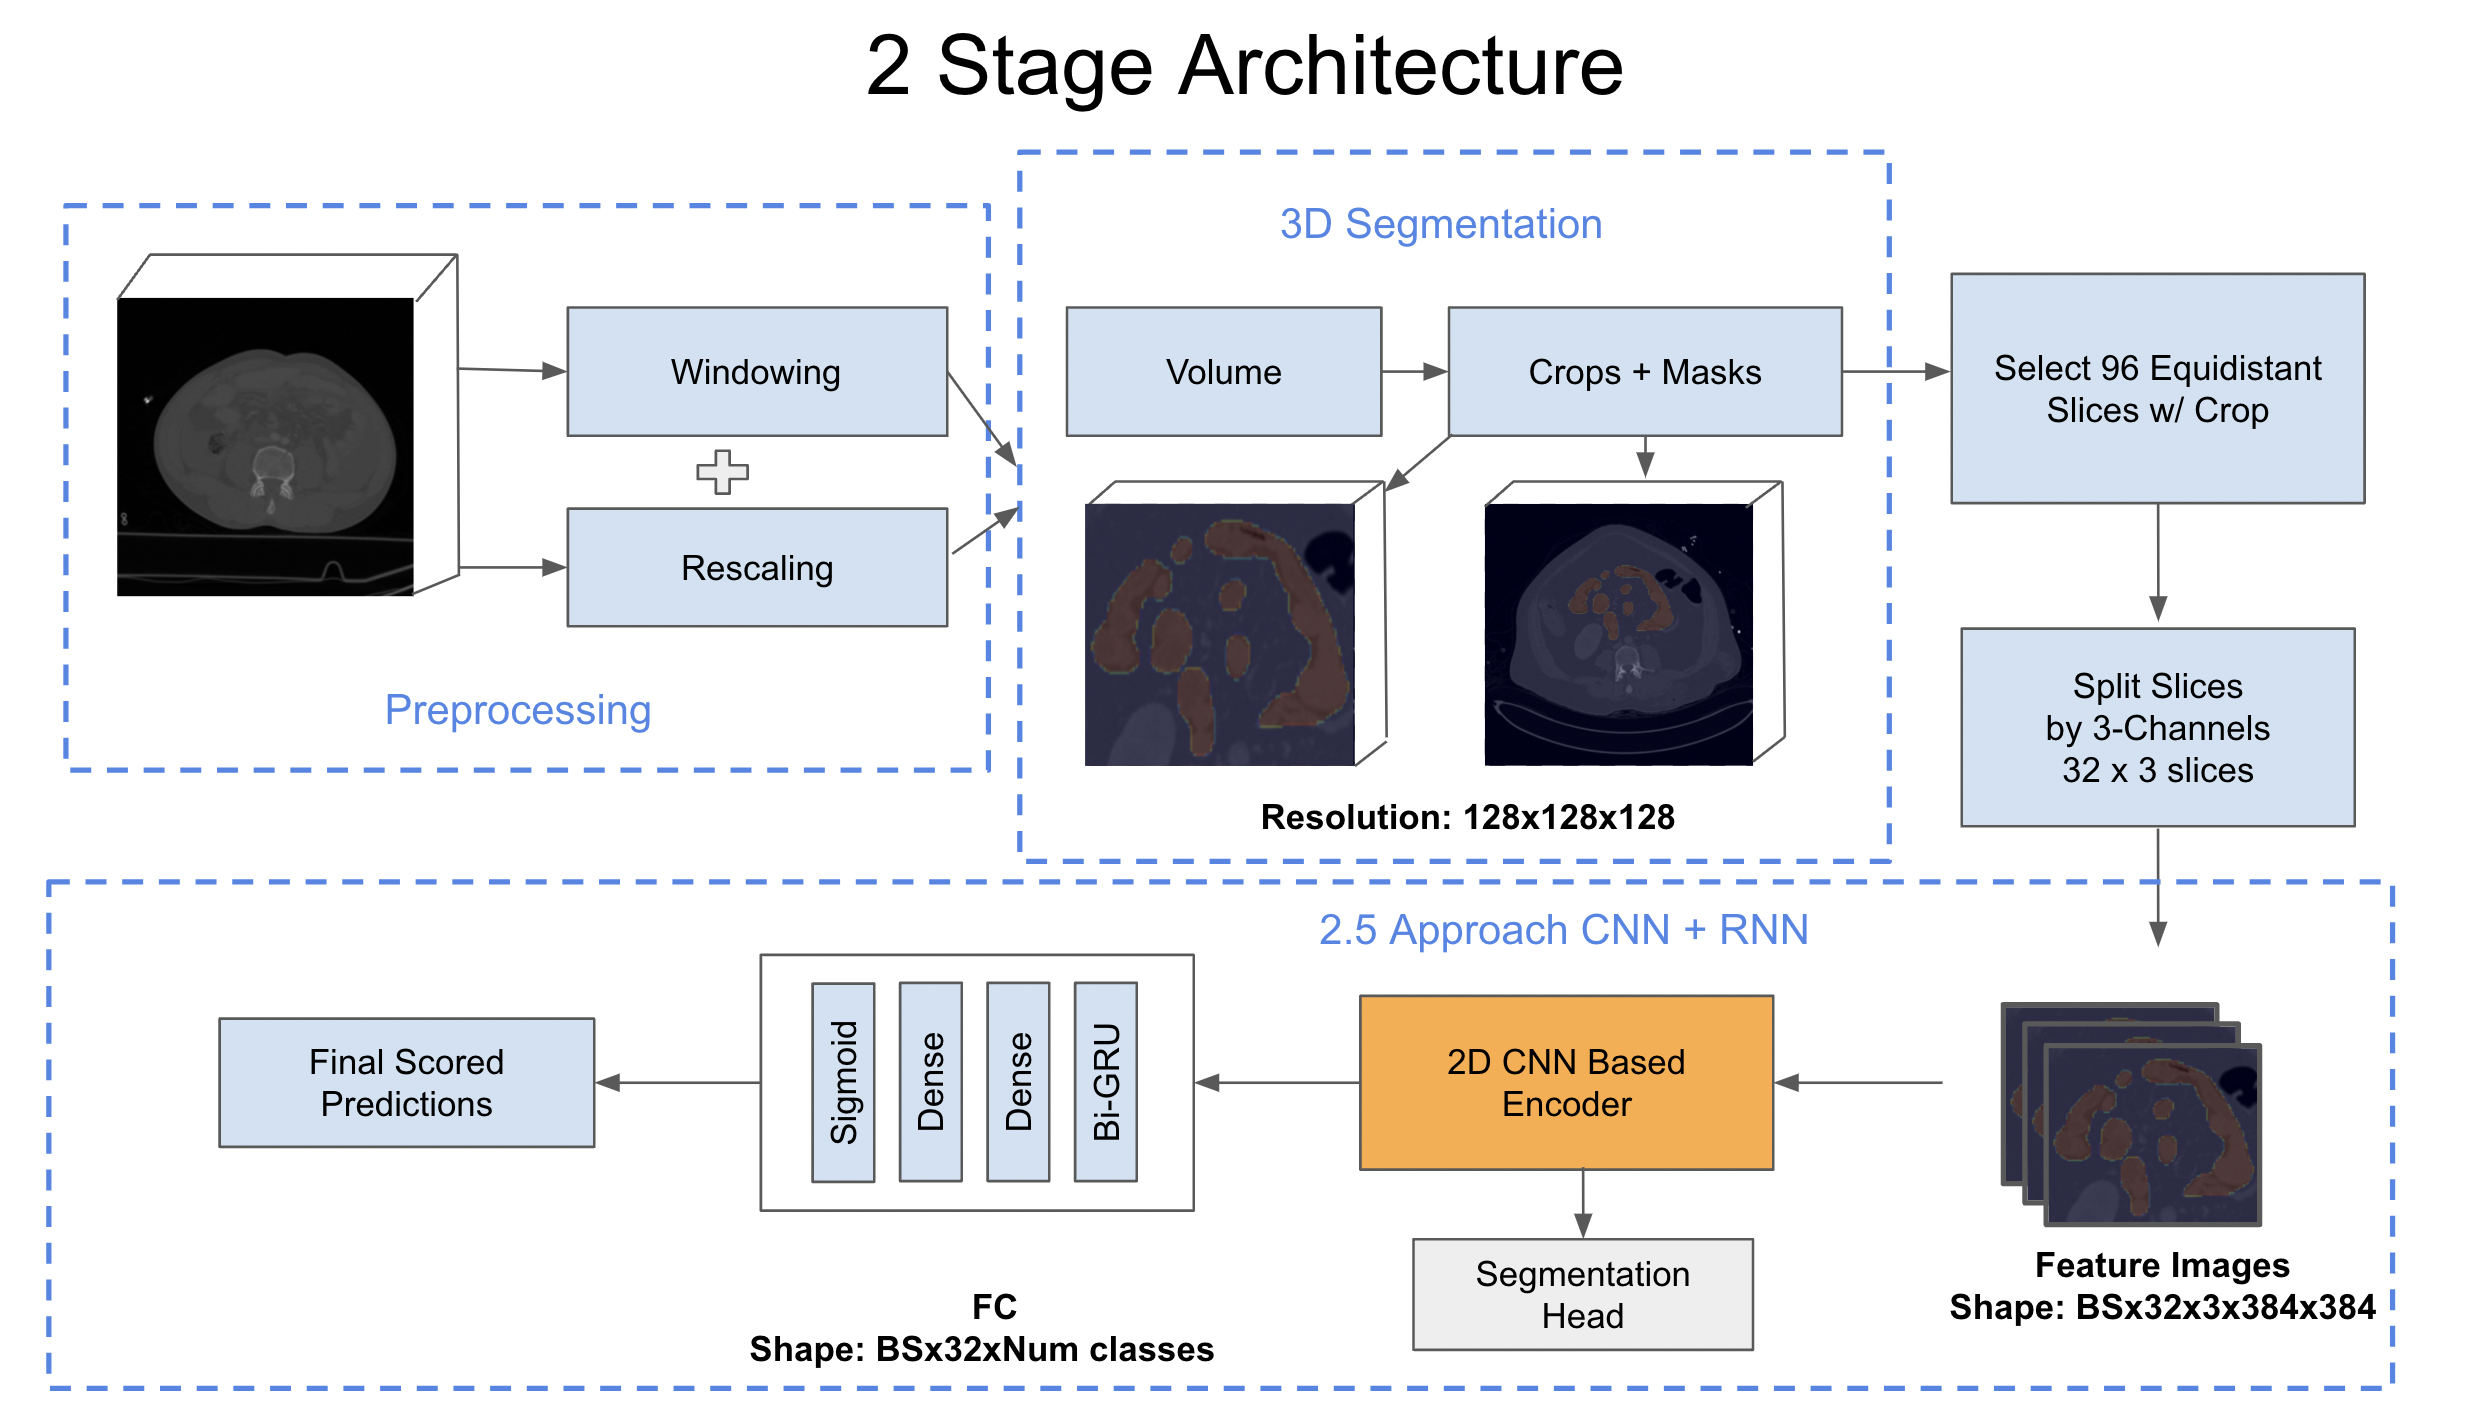

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

In [2]:

class UNETDecoder(nn.Module):
  def __init__(self, in_channels, res_channels, out_channels):
    super().__init__()
    self.up = nn.ConvTranspose2d(in_channels, out_channels, 2, stride=2)
    self.conv = nn.Sequential(
        nn.Conv2d(out_channels + res_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )
  def forward(self, x, res):
    x = self.up(x)
    x = torch.cat([x, res], dim=1)
    return self.conv(x)

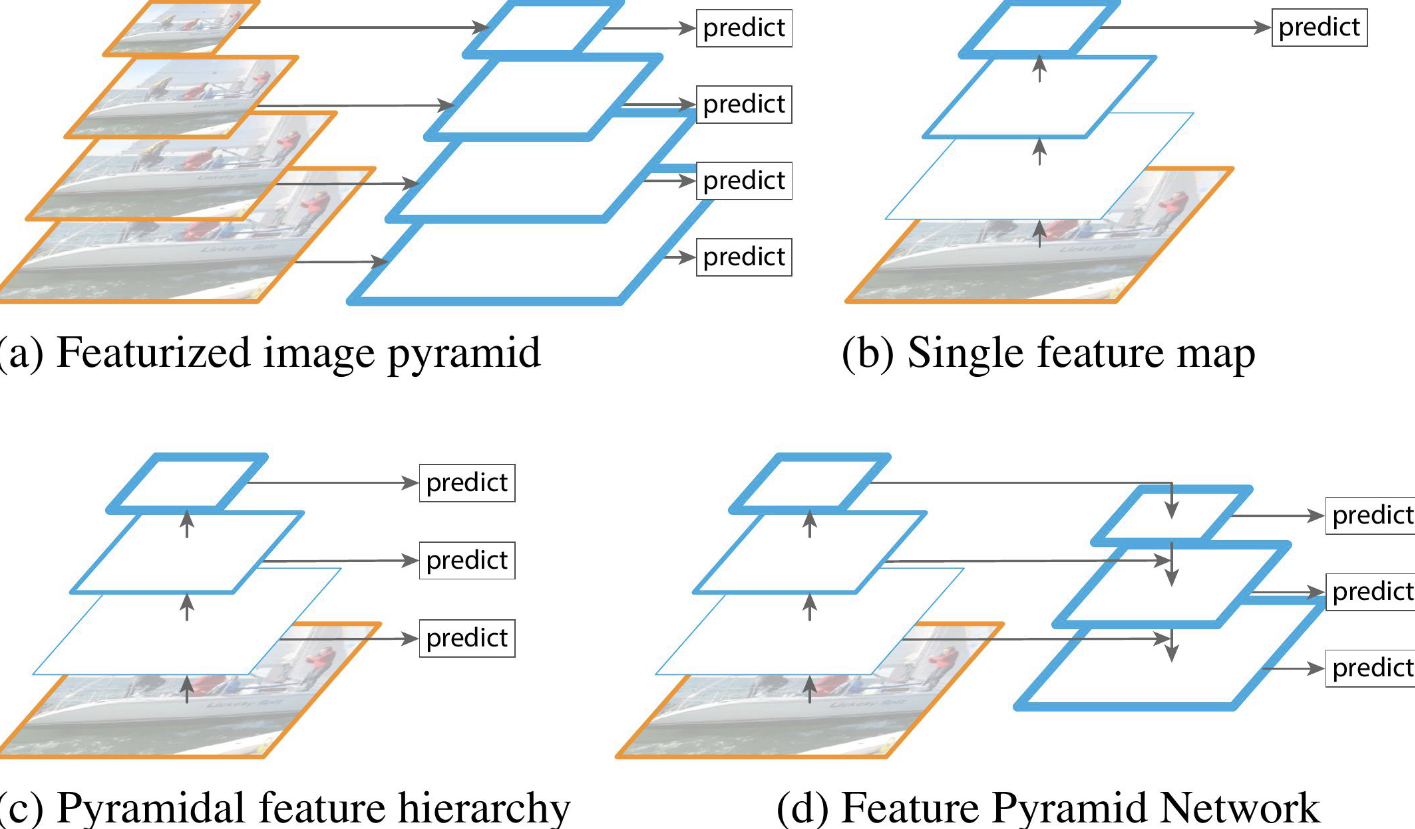

In [3]:
class FPN(nn.Module):
  def __init__(self, in_channels, out_channels, image_size=(112, 112)):
    super().__init__()
    self.image_size = image_size
    self.convs = nn.ModuleList()
    for in_channel, out_channel in zip(in_channels, out_channels):
      self.convs.append(nn.Sequential(
          nn.Conv2d(in_channel, out_channel*2, 3, padding=1),
          nn.ReLU(inplace=True),
          nn.BatchNorm2d(out_channel*2),
          nn.Conv2d(out_channel*2, out_channel, 3, padding=1),
      ))

  def forward(self, list_slice):
    res = [
        F.interpolate(conv(x), size=self.image_size, mode='bilinear', align_corners=False)
        for conv, x in zip(self.convs, list_slice)
    ]
    return torch.cat(res, dim=1)


In [4]:
in_channels = [384, 192, 96, 64]
out_channels = [32] * 4
fpn = FPN(in_channels, out_channels)
x1 = torch.randn(1, 384, 244, 112)
x2 = torch.randn(1, 192, 224, 224)
x3 = torch.randn(1, 96, 448, 448)
x4 = torch.randn(1, 64, 896, 89)
xs = [x1, x2, x3, x4]
output = fpn(xs)
print(output.shape)

torch.Size([1, 128, 112, 112])


In [5]:
class SegmentationHead(nn.Module):
  def __init__(self, image_size=(112, 112)):
    super().__init__()
    self.image_size = image_size

    unet_in_channels = [64, 96, 192, 384, 768]
    unet_out_channels = [384, 192, 96, 64]
    output_channels = 32
    self.unet_decoder = nn.ModuleList()
    print(unet_in_channels[::-1][:-1])
    for i, (in_channel, res_channel) in enumerate(zip(unet_in_channels[::-1][:-1], unet_out_channels)):
      self.unet_decoder.append(
          UNETDecoder(in_channel, res_channel, unet_out_channels[i])
      )
    self.fpn = FPN(unet_out_channels, [output_channels] * 4)
    current_channels = output_channels * 4
    intermediate_channels = [current_channels // 2**i for i in range(4)]
    inter_layers = []
    for ic in intermediate_channels:
      inter_layers.append(nn.Sequential(
          nn.Conv2d(current_channels, ic, 3, padding=1),
          nn.BatchNorm2d(ic),
          nn.ReLU(inplace=True),
      ))
      current_channels = ic
    inter_layers.append(nn.Conv2d(current_channels, 1, 1))
    self.cnn_seg_layer = nn.Sequential(*inter_layers)

  def forward(self, features):
    enc4_feats, enc3_feats, enc2_feats, enc1_feats, input = features
    dec4_feats = self.unet_decoder[0](enc4_feats, enc3_feats)
    dec3_feats = self.unet_decoder[1](dec4_feats, enc2_feats)
    dec2_feats = self.unet_decoder[2](dec3_feats, enc1_feats)
    dec1_feats = self.unet_decoder[3](dec2_feats, input)
    fpn_feats = self.fpn([dec4_feats, dec3_feats, dec2_feats, dec1_feats])

    x = F.interpolate(fpn_feats, size=self.image_size, mode='bilinear', align_corners=False)
    x = self.cnn_seg_layer(x)
    return x

In [6]:
seg_head = SegmentationHead()
enc4 = torch.randn(1, 768, 112, 112)
enc3 = torch.randn(1, 384, 224, 224)
enc2 = torch.randn(1, 192, 448, 448)
enc1 = torch.randn(1, 96, 896, 896)
input = torch.randn(1, 64, 1792, 1792)
output = seg_head([enc4, enc3, enc2, enc1, input])
print(output.shape)

[768, 384, 192, 96]
torch.Size([1, 1, 112, 112])


In [10]:
class _25DCnnRnnSeg(nn.Module):
  '''
  CNN model + LSTM + Segmentation Head
  '''
  def __init__(self, encoder, num_classes, num_classes_seg, n_channels=3, n_frames=1, dropout=0.1):
    super().__init__()
    self.encoder = encoder
    self.num_features = encoder.num_features
    self.num_classes = num_classes
    self.num_classes_seg = num_classes_seg
    self.n_channels = n_channels
    self.n_frames = n_frames
    self.dropout = nn.Dropout(dropout) if dropout else nn.Identity()

    self.lstm = nn.LSTM(
        input_size = self.num_features,
        hidden_size = self.num_features // 4,
        batch_first = True,
        bidirectional = True,
    )
    self.last_layer = nn.Linear(self.num_features, self.num_classes)
    self.seg_head = SegmentationHead()

    def extract_features(self, x):
      feature_output = self.encoder(x)
      intermediate_feature = None
      if self.segmentation_aux and 'coat' in self.encoder.name:
          layer0_encoder_feature = self.encoder.stem(x)
          layer1_encoder_feature = self.encoder.stages[0](layer0_encoder_feature)
          layer2_encoder_feature = self.encoder.stages[1](layer1_encoder_feature)
          layer3_encoder_feature = self.encoder.stages[2](layer2_encoder_feature)
          layer4_encoder_feature = self.encoder.stages[3](layer3_encoder_feature)

          intermediate_features = [
              layer4_encoder_feature,
              layer3_encoder_feature,
              layer2_encoder_feature,
              layer1_encoder_feature,
              layer0_encoder_feature
              ]

      fts = self.dropout(fts)
      return fts, intermediate_features

  def forward_lstm(self, x):
    x, _ = self.lstm(x)
    return torch.cat([x.mean(1), x.amax(1)], dim=1)

  def forward(self, x):
    B, n_frames, C, H, W = x.shape
    x = x.view(B * n_frames, C, H, W)

    features_output, inter_features = self.extract_features(x)
    features_output = features_output.view(B, n_frames, -1)
    features_output = self.forward_lstm(features_output)
    output = self.last_layer(features_output)

    seg_output = self.seg_head(inter_features)
    return output, seg_output



In [16]:
lstm = nn.LSTM(
    input_size=12,
    hidden_size=12 // 4,
    batch_first=True,
    bidirectional=True,
)
class LS(nn.Module):
  def __init__(self):
    super().__init__()
    self.lstm = nn.LSTM(
        input_size=12,
        hidden_size=12 // 4,
        batch_first=True,
        bidirectional=True,
    )
  def forward(self, x):
    x, _ = self.lstm(x)
    print(x.shape)
    print(x.mean(1).shape)
    print(x.amax(1).shape)
    return torch.cat([x.mean(1), x.amax(1)], dim=1)

lstm_input = torch.randn(3, 5, 12)
model = LS()
output = model(lstm_input)
print(output.shape)

torch.Size([3, 5, 6])
torch.Size([3, 6])
torch.Size([3, 6])
torch.Size([3, 12])
